# Introduction to Graph Attention Networks (GATs)

##  Simple Graph Creation and Visualization

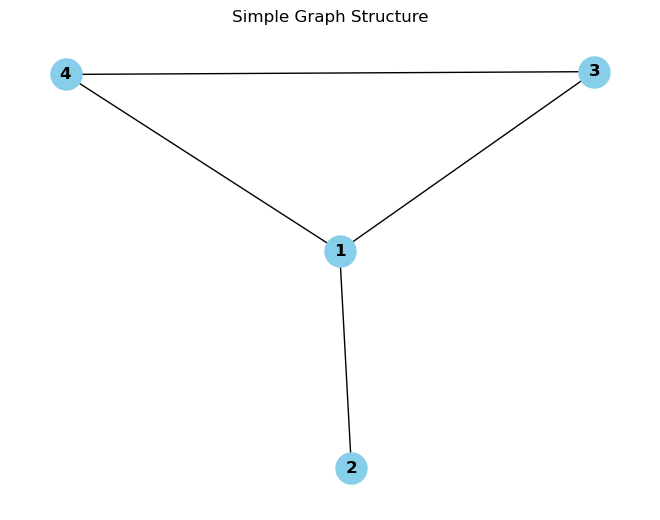

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

# Create an empty undirected graph
G = nx.Graph()

# Add 4 nodes to the graph (labeled 1, 2, 3, 4)
G.add_nodes_from([1, 2, 3, 4])

# Add edges to create connections between nodes
# Node 1 is connected to nodes 2, 3, and 4 (hub node)
# Node 3 is also connected to node 4
G.add_edge(1, 2)
G.add_edge(1, 3)
G.add_edge(1, 4)
G.add_edge(3, 4)

# Visualize the graph structure
pos = nx.spring_layout(G)  # Calculate node positions using spring layout algorithm
nx.draw(G, pos, with_labels=True, node_size=500, node_color="skyblue", 
        font_size=12, font_weight='bold')
plt.title("Simple Graph Structure")
plt.show()

## Get the Adjacency Matrix

In [2]:
# Calculate and display the adjacency matrix
# The adjacency matrix A represents graph connectivity where A[i,j] = 1 if nodes i and j are connected
adjacency_matrix = nx.adjacency_matrix(G).toarray()
print("Adjacency Matrix A:")
print(adjacency_matrix)
print("\nInterpretation: 1 indicates an edge between nodes, 0 indicates no connection")

Adjacency Matrix A:
[[0 1 1 1]
 [1 0 0 0]
 [1 0 0 1]
 [1 0 1 0]]

Interpretation: 1 indicates an edge between nodes, 0 indicates no connection


## Self-Attention Mechanism for Graphs

In [3]:
class SelfAttentionGraph:
    """
    Implements a simplified self-attention mechanism for graph-structured data.
    
    The self-attention mechanism allows each node to attend to its neighbors,
    computing weighted representations based on learned attention scores.
    """
    
    def __init__(self, G, num_features):
        """
        Initialize the self-attention graph layer.
        
        Args:
            G: NetworkX graph object
            num_features: Dimensionality of node feature vectors
        """
        self.G = G
        self.num_nodes = len(G.nodes)
        self.num_features = num_features
        # Initialize learnable attention weight vector randomly
        # In practice, this would be learned during training
        self.a_k = np.random.rand(num_features)
    
    def calculate_self_attention(self, node_features):
        """
        Calculate attention scores for all nodes in the graph.
        
        Args:
            node_features: Matrix of shape (num_nodes, num_features) containing node features
            
        Returns:
            final_attention: Attention scores masked by graph structure
        """
        # Step 1: Get the adjacency matrix to know which nodes are connected
        adjacency_matrix = nx.adjacency_matrix(self.G).toarray()
        
        # Step 2: Compute raw attention scores by projecting features onto attention vector
        # This produces a scalar score for each node
        attention_scores = np.dot(node_features, self.a_k)
        
        # Step 3: Apply LeakyReLU activation for non-linearity
        # LeakyReLU(x) = x if x > 0, else 0.2 * x (allows small negative values)
        leaky_relu = lambda x: x if x > 0 else 0.2 * x
        leaky_relu_vec = np.vectorize(leaky_relu)
        activated_attention_scores = leaky_relu_vec(attention_scores)
        
        # Step 4: Normalize attention scores using softmax
        # This ensures attention weights sum to 1 and are interpretable as probabilities
        attention_exp = np.exp(activated_attention_scores)
        attention_sum = np.sum(attention_exp)
        normalized_attention = attention_exp / attention_sum
        
        # Step 5: Mask attention scores using adjacency matrix
        # Only neighbors (and self) receive non-zero attention
        final_attention = np.dot(adjacency_matrix, normalized_attention)
        
        return final_attention
    
    def compute_final_features(self, node_features):
        """
        Compute final node representations using self-attention.
        
        Args:
            node_features: Input node feature matrix
            
        Returns:
            output_features: Aggregated features after applying attention
        """
        # Calculate attention weights
        final_attention = self.calculate_self_attention(node_features)
        
        # Aggregate neighbor features weighted by attention scores
        output_features = np.dot(final_attention, node_features)
        
        return output_features

In [4]:
# Generate random node features for demonstration
# In real applications, these would be meaningful feature vectors
num_features = 4
node_features = np.random.rand(len(G.nodes), num_features)
print(f"\nInput Node Features (shape: {node_features.shape}):")
print(node_features)

# Create self-attention instance and compute output
self_attention_graph = SelfAttentionGraph(G, num_features=num_features)
output_features = self_attention_graph.compute_final_features(node_features)

print("\nOutput Features after Self-Attention:")
print(output_features)
print("\nNote: Output features are aggregations of neighbor features weighted by attention")


Input Node Features (shape: (4, 4)):
[[0.61516257 0.48941147 0.19694975 0.12692629]
 [0.45754885 0.5660291  0.86130938 0.05988929]
 [0.80828913 0.89189855 0.31532289 0.89507043]
 [0.59026726 0.60307866 0.68100652 0.18307148]]

Output Features after Self-Attention:
[1.20972557 1.16167803 0.76059266 0.575341  ]

Note: Output features are aggregations of neighbor features weighted by attention


## Challenge 1:
Use the karate_club_graph from NetworkX and Compute the Self-attention

- Use the following code for Help

```python
import networkx as nx
import matplotlib.pyplot as plt

# Load dataset
G = nx.karate_club_graph()

# Process labels (Mr. Hi = 0, Officer = 1)
labels = []
for node in G.nodes:
    label = G.nodes[node]['club']
    labels.append(1 if label == 'Officer' else 0)

# Plot graph
plt.figure(figsize=(12,12))
plt.axis('off')
nx.draw_networkx(G,
                 pos=nx.spring_layout(G, seed=0),
                 node_color=labels,
                 node_size=800,
                 cmap='coolwarm',
                 font_size=14,
                 font_color='white'
                 )
```

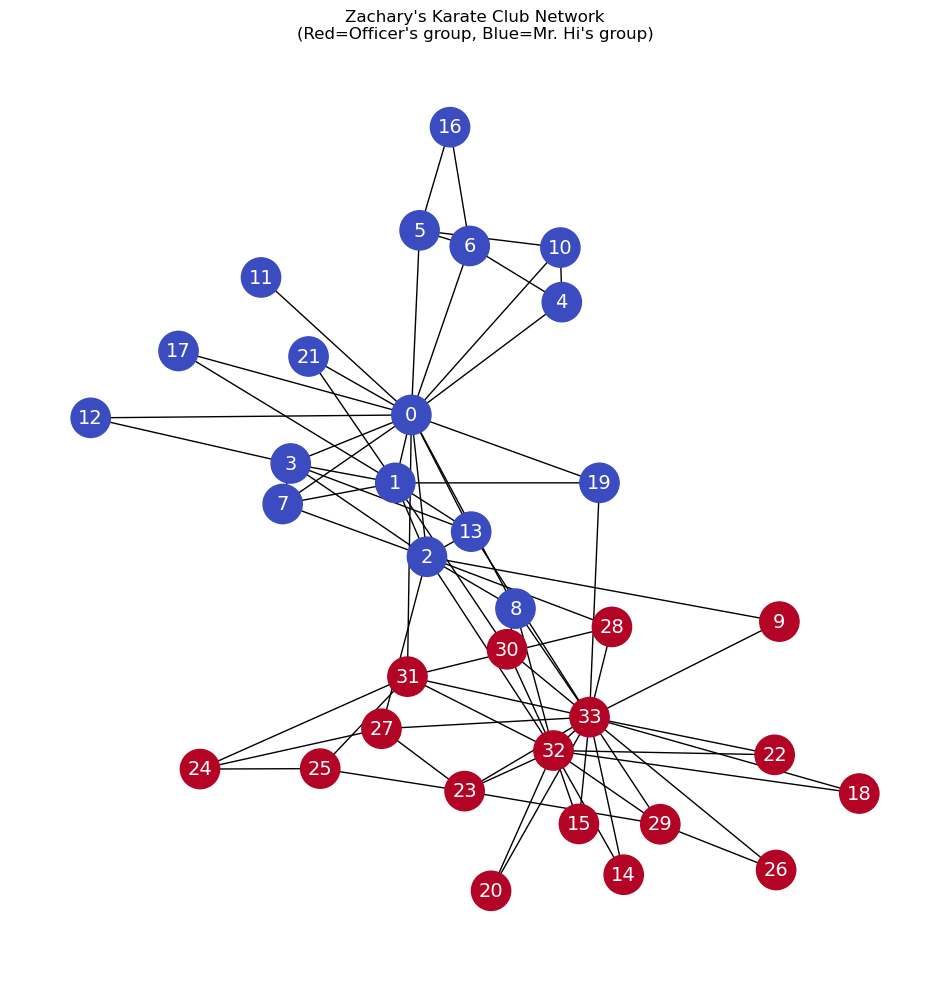


Karate Club Self-Attention Results:
Number of nodes: 34
Output feature shape: (8,)
Sample output features for first 3 nodes:
[7.14659367 6.53234233 6.12364364]


In [5]:
# Load the Zachary's Karate Club dataset
karate_G = nx.karate_club_graph()

# Extract labels (0 = Mr. Hi's group, 1 = Officer's group)
labels = []
for node in karate_G.nodes:
    label = karate_G.nodes[node]['club']
    labels.append(1 if label == 'Officer' else 0)

# Visualize the karate club network
plt.figure(figsize=(12, 12))
plt.axis('off')
nx.draw_networkx(
    karate_G,
    pos=nx.spring_layout(karate_G, seed=0),
    node_color=labels,
    node_size=800,
    cmap='coolwarm',
    font_size=14,
    font_color='white'
)
plt.title("Zachary's Karate Club Network\n(Red=Officer's group, Blue=Mr. Hi's group)")
plt.show()

# Apply self-attention to the karate club graph
num_karate_features = 8  # Using 8 features per node
karate_node_features = np.random.rand(len(karate_G.nodes), num_karate_features)

# Create and apply self-attention
karate_attention = SelfAttentionGraph(karate_G, num_features=num_karate_features)
karate_output = karate_attention.compute_final_features(karate_node_features)

print(f"\nKarate Club Self-Attention Results:")
print(f"Number of nodes: {len(karate_G.nodes)}")
print(f"Output feature shape: {karate_output.shape}")
print(f"Sample output features for first 3 nodes:")
print(karate_output[:3])

In [6]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid, FacebookPagePage
from torch_geometric.nn import GATv2Conv, GCNConv
from torch_geometric.utils import degree
from collections import Counter

# Set random seed for reproducibility
torch.manual_seed(1)
np.random.seed(1)

In [7]:
# The Cora dataset is a citation network where:
# - Nodes represent scientific papers
# - Edges represent citation relationships
# - Features are bag-of-words representations of papers
# - Labels are research topics (7 classes)


# Download and load the Cora dataset
dataset = Planetoid(root=".", name="Cora")
data = dataset[0]

# Display dataset statistics
print("\n" + "="*50)
print("CORA DATASET INFORMATION")
print("="*50)
print(f'Dataset: {dataset}')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of nodes: {data.x.shape[0]}')
print(f'Number of features per node: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')
print(f'Number of edges: {data.edge_index.shape[1]}')
print(f'Training nodes: {data.train_mask.sum()}')
print(f'Validation nodes: {data.val_mask.sum()}')
print(f'Test nodes: {data.test_mask.sum()}')


CORA DATASET INFORMATION
Dataset: Cora()
Number of graphs: 1
Number of nodes: 2708
Number of features per node: 1433
Number of classes: 7
Number of edges: 10556
Training nodes: 140
Validation nodes: 500
Test nodes: 1000


Processing...
Done!


## Visualize Node Degree Distribution

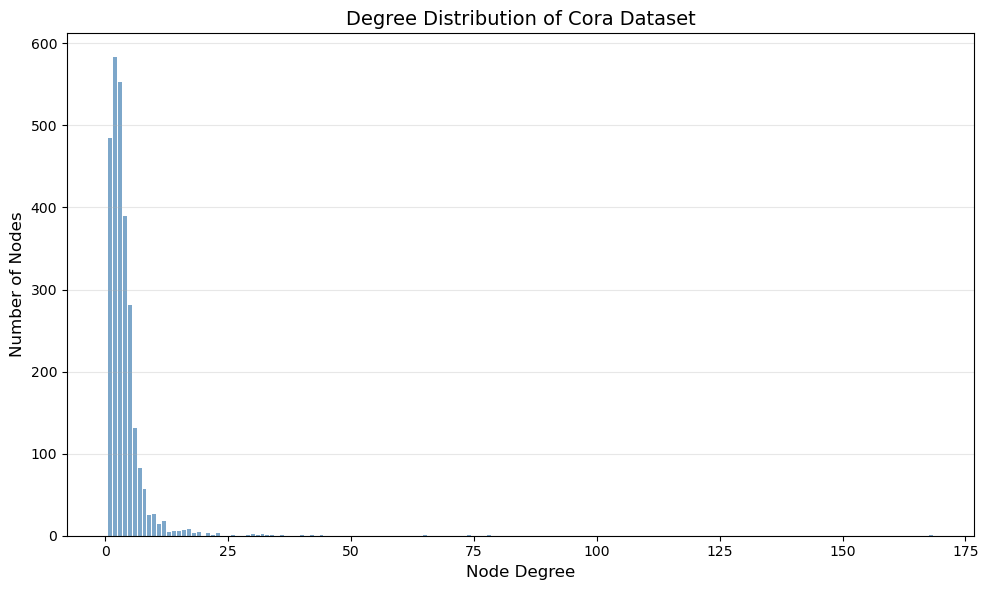


Degree Statistics:
Average degree: 3.90
Maximum degree: 168
Minimum degree: 1


In [8]:
# Calculate degree (number of connections) for each node
degrees = degree(data.edge_index[0]).numpy()

# Count frequency of each degree value
degree_counts = Counter(degrees)

# Create bar plot of degree distribution
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlabel('Node Degree', fontsize=12)
ax.set_ylabel('Number of Nodes', fontsize=12)
ax.set_title('Degree Distribution of Cora Dataset', fontsize=14)
plt.bar(degree_counts.keys(), degree_counts.values(), color='steelblue', alpha=0.7)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nDegree Statistics:")
print(f"Average degree: {degrees.mean():.2f}")
print(f"Maximum degree: {degrees.max():.0f}")
print(f"Minimum degree: {degrees.min():.0f}")

In [9]:
# Helper function
def accuracy(y_pred, y_true):
    """
    Calculate classification accuracy.
    
    Args:
        y_pred: Predicted class labels
        y_true: Ground truth labels
        
    Returns:
        Accuracy as a float between 0 and 1
    """
    return torch.sum(y_pred == y_true) / len(y_true)

## Implementing the GAT Class using the pre-built Using the Built-In implementation from `GATv2Conv` module of `torch_geometric.nn`

In [11]:
class GAT(torch.nn.Module):
    """
    Graph Attention Network (GAT) for node classification.
    
    Architecture:
    - Input Layer: Node features
    - Hidden Layer: GATv2Conv with multiple attention heads
    - Output Layer: GATv2Conv with single attention head
    - Activation: ELU (Exponential Linear Unit)
    - Regularization: Dropout (0.6)
    """
    
    def __init__(self, dim_in, dim_h, dim_out, heads=8):
        """
        Initialize GAT model.
        
        Args:
            dim_in: Input feature dimension
            dim_h: Hidden layer dimension
            dim_out: Output dimension (number of classes)
            heads: Number of attention heads in first layer
        """
        super().__init__()
        
        # First GAT layer with multiple attention heads
        # Each head learns different attention patterns
        self.gat1 = GATv2Conv(dim_in, dim_h, heads=heads)
        
        # Second GAT layer: combines multi-head outputs to final prediction
        # Input dimension is dim_h * heads because we concatenate all head outputs
        self.gat2 = GATv2Conv(dim_h * heads, dim_out, heads=1)
    
    def forward(self, x, edge_index):
        """
        Forward pass through the network.
        
        Args:
            x: Node feature matrix of shape (num_nodes, num_features)
            edge_index: Graph connectivity in COO format of shape (2, num_edges)
            
        Returns:
            Log probabilities for each class
        """
        # Apply dropout to input features (regularization)
        h = F.dropout(x, p=0.6, training=self.training)
        
        # First GAT layer: transform and aggregate neighbor features
        h = self.gat1(h, edge_index)
        
        # Apply ELU activation (smooth, non-linear transformation)
        h = F.elu(h)
        
        # Apply dropout after first layer
        h = F.dropout(h, p=0.6, training=self.training)
        
        # Second GAT layer: final transformation to class logits
        h = self.gat2(h, edge_index)
        
        # Apply log softmax for numerical stability in classification
        return F.log_softmax(h, dim=1)
    
    def fit(self, data, epochs):
        """
        Train the GAT model.
        
        Args:
            data: PyTorch Geometric data object containing graph and features
            epochs: Number of training iterations
        """
        # Define loss function (cross-entropy for classification)
        criterion = torch.nn.CrossEntropyLoss()
        
        # Define optimizer (Adam with L2 regularization)
        optimizer = torch.optim.Adam(
            self.parameters(), 
            lr=0.01,  # Learning rate
            weight_decay=0.01  # L2 regularization strength
        )
        
        # Set model to training mode
        self.train()
        
        # Lists to store metrics for visualization
        train_losses, val_losses = [], []
        train_accs, val_accs = [], []
        
        for epoch in range(epochs + 1):
            # Zero gradients from previous iteration
            optimizer.zero_grad()
            
            # Forward pass: compute predictions
            out = self(data.x, data.edge_index)
            
            # Compute loss only on training nodes
            loss = criterion(out[data.train_mask], data.y[data.train_mask])
            
            # Compute training accuracy
            acc = accuracy(
                out[data.train_mask].argmax(dim=1),
                data.y[data.train_mask]
            )
            
            # Backward pass: compute gradients
            loss.backward()
            
            # Update weights
            optimizer.step()
            
            # Log progress every 20 epochs
            if epoch % 20 == 0:
                # Compute validation metrics
                val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
                val_acc = accuracy(
                    out[data.val_mask].argmax(dim=1),
                    data.y[data.val_mask]
                )
                
                print(f'Epoch {epoch:>3} | '
                      f'Train Loss: {loss:.3f} | Train Acc: {acc*100:>5.2f}% | '
                      f'Val Loss: {val_loss:.2f} | Val Acc: {val_acc*100:>5.2f}%')
                
                # Store metrics for plotting
                train_losses.append(loss.item())
                val_losses.append(val_loss.item())
                train_accs.append(acc.item())
                val_accs.append(val_acc.item())
        
        return train_losses, val_losses, train_accs, val_accs
    
    @torch.no_grad()
    def test(self, data):
        """
        Evaluate model on test set.
        
        Args:
            data: PyTorch Geometric data object
            
        Returns:
            Test accuracy
        """
        # Set model to evaluation mode (disables dropout)
        self.eval()
        
        # Forward pass
        out = self(data.x, data.edge_index)
        
        # Compute test accuracy
        acc = accuracy(
            out.argmax(dim=1)[data.test_mask],
            data.y[data.test_mask]
        )
        
        return acc

In [12]:
# Create GAT model instance
gat = GAT(
    dim_in=dataset.num_features,  # 1433 features
    dim_h=32,  # 32-dimensional hidden representations
    dim_out=dataset.num_classes,  # 7 output classes
    heads=8  # 8 attention heads
)

print(f"\nModel Architecture:")
print(gat)
print(f"\nTotal parameters: {sum(p.numel() for p in gat.parameters())}")

# Train the model
train_losses, val_losses, train_accs, val_accs = gat.fit(data, epochs=100)

# Evaluate on test set
test_acc = gat.test(data)

print(f'GAT Test Accuracy: {test_acc*100:.2f}%')


Model Architecture:
GAT(
  (gat1): GATv2Conv(1433, 32, heads=8)
  (gat2): GATv2Conv(256, 7, heads=1)
)

Total parameters: 738332
Epoch   0 | Train Loss: 1.968 | Train Acc: 14.29% | Val Loss: 1.96 | Val Acc: 13.20%
Epoch  20 | Train Loss: 0.203 | Train Acc: 98.57% | Val Loss: 0.91 | Val Acc: 71.60%
Epoch  40 | Train Loss: 0.163 | Train Acc: 97.86% | Val Loss: 0.95 | Val Acc: 70.40%
Epoch  60 | Train Loss: 0.171 | Train Acc: 97.86% | Val Loss: 0.87 | Val Acc: 71.40%
Epoch  80 | Train Loss: 0.173 | Train Acc: 97.86% | Val Loss: 0.89 | Val Acc: 73.80%
Epoch 100 | Train Loss: 0.154 | Train Acc: 97.14% | Val Loss: 0.92 | Val Acc: 72.60%
GAT Test Accuracy: 80.90%


### Visualization

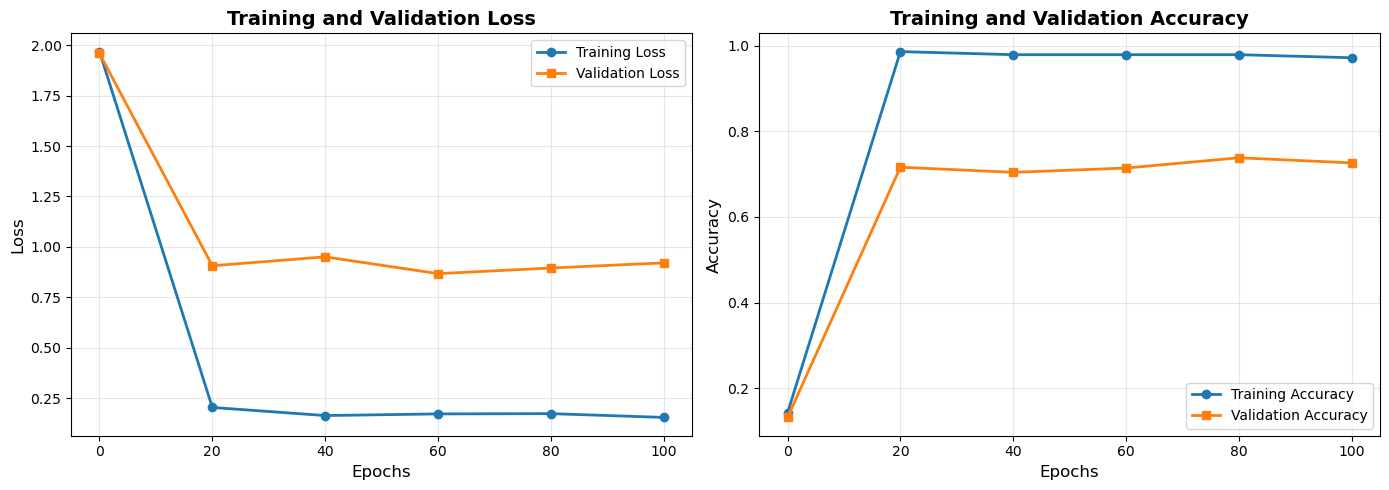

In [13]:
epochs_list = range(0, 101, 20)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot loss curves
ax1.plot(epochs_list, train_losses, label='Training Loss', marker='o', linewidth=2)
ax1.plot(epochs_list, val_losses, label='Validation Loss', marker='s', linewidth=2)
ax1.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epochs', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Plot accuracy curves
ax2.plot(epochs_list, train_accs, label='Training Accuracy', marker='o', linewidth=2)
ax2.plot(epochs_list, val_accs, label='Validation Accuracy', marker='s', linewidth=2)
ax2.set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epochs', fontsize=12)
ax2.set_ylabel('Accuracy', fontsize=12)
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()